In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
import logging
from tqdm import tqdm

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

class FeatureExtractor:
    """Class for extracting and processing features for AI detection."""
    
    def __init__(self):
        """Initialize the feature extractor."""
        self.scaler = StandardScaler()
        self.feature_selector = None
        self.pca = None
    
    def get_similarity_features(self, df, model_prefixes=None):
        """
        Extract similarity features from DataFrame for all regeneration models.
        
        Args:
            df (pd.DataFrame): DataFrame containing similarity metrics
            model_prefixes (list): List of model prefixes (e.g., ['gpt', 'mistral', 'claude'])
                                  If None, will be extracted from column names
        
        Returns:
            tuple: (X, feature_names)
        """
        # If no model prefixes provided, extract them from column names
        if model_prefixes is None:
            # Find all columns that end with the common similarity metrics
            sim_metrics = ['bleu', 'rouge_1_f', 'rouge_2_f', 'rouge_l_f', 
                          'levenshtein_sim', 'bert_sim', 'jaccard_sim']
            
            # Get all column names that end with one of these metrics
            sim_columns = []
            for metric in sim_metrics:
                sim_columns.extend([col for col in df.columns if col.endswith(f'_{metric}')])
            
            # Extract model prefixes
            model_prefixes = set()
            for col in sim_columns:
                prefix = col.split('_')[0]
                if prefix and prefix != 'text':
                    model_prefixes.add(prefix)
            
            model_prefixes = list(model_prefixes)
            logger.info(f"Extracted model prefixes: {model_prefixes}")
        
        # For each model, get all similarity features
        feature_names = []
        feature_matrices = []
        
        for prefix in model_prefixes:
            # Get all columns for this model
            model_cols = [col for col in df.columns if col.startswith(f'{prefix}_') and 
                         any(col.endswith(f'_{m}') for m in 
                             ['bleu', 'rouge_1_f', 'rouge_2_f', 'rouge_l_f', 
                              'levenshtein_sim', 'bert_sim', 'jaccard_sim'])]
            
            if not model_cols:
                logger.warning(f"No similarity features found for model prefix '{prefix}'")
                continue
                
            logger.info(f"Using {len(model_cols)} features for model prefix '{prefix}': {model_cols}")
            
            # Add to our feature list
            feature_names.extend(model_cols)
            
            # Get feature values and ensure they are numeric
            X_model = df[model_cols].apply(pd.to_numeric, errors='coerce').fillna(0).values
            feature_matrices.append(X_model)
        
        # Combine all features
        if feature_matrices:
            X = np.hstack(feature_matrices)
            return X, feature_names
        else:
            logger.error("No similarity features found in the DataFrame")
            return np.array([]), []
    
    def extract_statistical_features(self, df, text_col='text', regen_cols=None):
        """
        Extract statistical features from text and its regenerations.
        
        Args:
            df (pd.DataFrame): DataFrame containing text data
            text_col (str): Column containing original text
            regen_cols (list): List of columns containing regenerated texts
            
        Returns:
            pd.DataFrame: DataFrame with added statistical features
        """
        result_df = df.copy()
        
        # If no regeneration columns specified, try to find columns starting with 'regeneration_'
        if regen_cols is None:
            regen_cols = [col for col in df.columns if col.startswith('regeneration_')]
        
        # Extract features from original text
        logger.info("Extracting statistical features from original text")
        result_df['orig_word_count'] = df[text_col].apply(lambda x: len(str(x).split()))
        result_df['orig_char_count'] = df[text_col].apply(lambda x: len(str(x)))
        result_df['orig_avg_word_len'] = df[text_col].apply(
            lambda x: np.mean([len(w) for w in str(x).split()]) if len(str(x).split()) > 0 else 0
        )
        
        # Extract features from regenerations
        for regen_col in regen_cols:
            if regen_col in df.columns:
                prefix = regen_col.replace('regeneration_', '')
                logger.info(f"Extracting statistical features from {regen_col}")
                
                # Word count difference
                result_df[f'{prefix}_word_count_diff'] = df.apply(
                    lambda row: abs(len(str(row[regen_col]).split()) - len(str(row[text_col]).split())), 
                    axis=1
                )
                
                # Character count difference
                result_df[f'{prefix}_char_count_diff'] = df.apply(
                    lambda row: abs(len(str(row[regen_col])) - len(str(row[text_col]))), 
                    axis=1
                )
                
                # Average word length difference
                result_df[f'{prefix}_avg_word_len_diff'] = df.apply(
                    lambda row: abs(
                        np.mean([len(w) for w in str(row[regen_col]).split()]) if len(str(row[regen_col]).split()) > 0 else 0
                        - np.mean([len(w) for w in str(row[text_col]).split()]) if len(str(row[text_col]).split()) > 0 else 0
                    ),
                    axis=1
                )
            else:
                logger.warning(f"Regeneration column '{regen_col}' not found in DataFrame")
        
        return result_df
    
    def create_feature_ratios(self, df, base_features):
        """
        Create ratio features from base similarity features.
        
        Args:
            df (pd.DataFrame): DataFrame with similarity features
            base_features (list): List of base feature column names
            
        Returns:
            pd.DataFrame: DataFrame with added ratio features
        """
        result_df = df.copy()
        
        # Group features by their metric type
        metrics = {}
        for col in base_features:
            # Extract the metric name (last part of the column name)
            parts = col.split('_')
            metric = parts[-1]  # e.g., 'bleu', 'bert_sim', etc.
            
            if metric not in metrics:
                metrics[metric] = []
            metrics[metric].append(col)
        
        # Create ratios between different model results for the same metric
        for metric, columns in metrics.items():
            if len(columns) >= 2:
                logger.info(f"Creating ratio features for metric '{metric}'")
                
                for i, col1 in enumerate(columns):
                    for col2 in columns[i+1:]:
                        # Extract model names
                        model1 = col1.split('_')[0]
                        model2 = col2.split('_')[0]
                        
                        ratio_name = f'{model1}_{model2}_{metric}_ratio'
                        
                        # Compute ratio with handling for zeros
                        result_df[ratio_name] = df.apply(
                            lambda row: row[col1] / row[col2] if row[col2] != 0 else (
                                1.0 if row[col1] == 0 else float('inf')
                            ),
                            axis=1
                        )
                        
                        # Replace infinities with a large number and ensure numeric
                        result_df[ratio_name] = pd.to_numeric(
                            result_df[ratio_name].replace([float('inf'), -float('inf')], 1000.0),
                            errors='coerce'
                        ).fillna(0)
        
        return result_df
    
    def normalize_features(self, X, fit=True):
        """
        Normalize feature matrix using StandardScaler.
        
        Args:
            X (numpy.ndarray): Feature matrix
            fit (bool): Whether to fit the scaler or just transform
            
        Returns:
            numpy.ndarray: Normalized feature matrix
        """
        # Check if all values are numeric
        if not np.issubdtype(X.dtype, np.number):
            logger.warning("Non-numeric values found in feature matrix. Converting to numeric...")
            try:
                # Convert to float, replacing non-numeric values with 0
                X = np.array(X, dtype=float)
            except ValueError as e:
                logger.error(f"Failed to convert feature matrix to numeric: {e}")
                # Find problematic values
                for i in range(X.shape[0]):
                    for j in range(X.shape[1]):
                        try:
                            float(X[i, j])
                        except (ValueError, TypeError):
                            logger.error(f"Non-numeric value at position [{i}, {j}]: {X[i, j]}")
                            X[i, j] = 0.0  # Replace problematic value with 0
                
                # Try conversion again
                X = np.array(X, dtype=float)
        
        if fit:
            return self.scaler.fit_transform(X)
        else:
            return self.scaler.transform(X)
    
    def select_features(self, X, y, feature_names, k=20, fit=True):
        """
        Select top k features based on ANOVA F-value.
        
        Args:
            X (numpy.ndarray): Feature matrix
            y (numpy.ndarray): Target vector
            feature_names (list): List of feature names
            k (int): Number of features to select
            fit (bool): Whether to fit the selector or just transform
            
        Returns:
            tuple: (selected_X, selected_feature_names)
        """
        if fit:
            self.feature_selector = SelectKBest(f_classif, k=min(k, X.shape[1]))
            X_selected = self.feature_selector.fit_transform(X, y)
            
            # Get names of selected features
            selected_indices = self.feature_selector.get_support(indices=True)
            selected_feature_names = [feature_names[i] for i in selected_indices]
            
            logger.info(f"Selected {len(selected_feature_names)} features: {selected_feature_names}")
            return X_selected, selected_feature_names
        else:
            if self.feature_selector is None:
                logger.error("Feature selector not fitted")
                return X, feature_names
                
            X_selected = self.feature_selector.transform(X)
            
            # Get names of selected features
            selected_indices = self.feature_selector.get_support(indices=True)
            selected_feature_names = [feature_names[i] for i in selected_indices]
            
            return X_selected, selected_feature_names
    
    def apply_pca(self, X, n_components=0.95, fit=True):
        """
        Apply PCA dimensionality reduction.
        
        Args:
            X (numpy.ndarray): Feature matrix
            n_components (float or int): Number of components or variance to retain
            fit (bool): Whether to fit the PCA or just transform
            
        Returns:
            numpy.ndarray: Transformed feature matrix
        """
        if fit:
            self.pca = PCA(n_components=n_components)
            X_pca = self.pca.fit_transform(X)
            
            logger.info(f"PCA reduced dimensions from {X.shape[1]} to {X_pca.shape[1]} components")
            logger.info(f"Explained variance ratio: {sum(self.pca.explained_variance_ratio_):.4f}")
            
            return X_pca
        else:
            if self.pca is None:
                logger.error("PCA not fitted")
                return X
                
            X_pca = self.pca.transform(X)
            return X_pca
    
    def extract_all_features(self, df, label_col='label', text_col='text', 
                           regen_cols=None, model_prefixes=None, 
                           create_ratios=True, apply_feature_selection=True,
                           n_features=20, apply_pca_transform=False):
        """
        Full feature extraction pipeline.
        
        Args:
            df (pd.DataFrame): DataFrame with text and similarity data
            label_col (str): Column containing labels
            text_col (str): Column containing original text
            regen_cols (list): List of regeneration columns
            model_prefixes (list): List of model prefixes
            create_ratios (bool): Whether to create ratio features
            apply_feature_selection (bool): Whether to apply feature selection
            n_features (int): Number of features to select
            apply_pca_transform (bool): Whether to apply PCA
            
        Returns:
            tuple: (X, y, feature_names)
        """
        # Check if label column exists
        if label_col not in df.columns:
            logger.error(f"Label column '{label_col}' not found in DataFrame")
            raise ValueError(f"Label column '{label_col}' not found in DataFrame")
        
        # Extract labels and ensure they're numeric
        try:
            y = pd.to_numeric(df[label_col], errors='coerce').fillna(0).values
        except Exception as e:
            logger.error(f"Error converting labels to numeric: {e}")
            # Try to work with string labels
            unique_labels = df[label_col].unique()
            label_map = {label: i for i, label in enumerate(unique_labels)}
            y = np.array([label_map.get(label, 0) for label in df[label_col]])
            logger.info(f"Converted string labels to numeric: {label_map}")
        
        # Get similarity features
        X_sim, sim_feature_names = self.get_similarity_features(df, model_prefixes)
        
        # Extract statistical features
        df_with_stats = self.extract_statistical_features(df, text_col, regen_cols)
        
        # Identify statistical feature columns
        stat_cols = [col for col in df_with_stats.columns if any(
            x in col for x in ['word_count', 'char_count', 'avg_word_len']
        )]
        
        # Ensure statistical features are numeric
        X_stats = df_with_stats[stat_cols].apply(pd.to_numeric, errors='coerce').fillna(0).values
        
        # Combine features
        X = np.hstack([X_sim, X_stats])
        feature_names = sim_feature_names + stat_cols
        
        logger.info(f"Combined feature matrix shape: {X.shape}")
        
        # Create ratio features if requested
        if create_ratios and len(sim_feature_names) > 1:
            df_with_ratios = self.create_feature_ratios(df, sim_feature_names)
            
            # Identify ratio columns
            ratio_cols = [col for col in df_with_ratios.columns if 'ratio' in col]
            
            if ratio_cols:
                X_ratios = df_with_ratios[ratio_cols].apply(pd.to_numeric, errors='coerce').fillna(0).values
                X = np.hstack([X, X_ratios])
                feature_names += ratio_cols
                
                logger.info(f"Added {len(ratio_cols)} ratio features, new shape: {X.shape}")
        
        # Normalize features
        X_norm = self.normalize_features(X)
        
        # Apply feature selection if requested
        if apply_feature_selection:
            X_norm, feature_names = self.select_features(X_norm, y, feature_names, k=n_features)
        
        # Apply PCA if requested
        if apply_pca_transform:
            X_norm = self.apply_pca(X_norm)
            # Note: feature_names no longer apply after PCA
        
        return X_norm, y, feature_names

def main():
    """Demonstrate the feature extraction functionality."""
    try:
        # Load data with similarity metrics
        df = pd.read_csv('data/processed/similarity_features.csv')
        logger.info(f"Loaded dataset with {len(df)} rows and {len(df.columns)} columns")
        
        # Initialize feature extractor
        extractor = FeatureExtractor()
        
        # Extract features
        X, y, feature_names = extractor.extract_all_features(
            df, 
            label_col='label',
            text_col='text',
            create_ratios=True,
            apply_feature_selection=True,
            n_features=20
        )
        
        # Save feature matrix
        np.save('data/processed/feature_matrix.npy', X)
        np.save('data/processed/labels.npy', y)
        
        # Save feature names
        with open('data/processed/feature_names.txt', 'w') as f:
            for name in feature_names:
                f.write(f"{name}\n")
        
        logger.info(f"Extracted features saved to disk. X shape: {X.shape}")
        
        # Display sample of feature matrix
        print("\nSample of feature matrix:")
        sample_df = pd.DataFrame(X[:5], columns=[f"Feature_{i}" for i in range(X.shape[1])])
        print(sample_df)
        
    except Exception as e:
        logger.error(f"Error in feature extraction demonstration: {e}")
        raise

if __name__ == "__main__":
    main()

2025-05-12 22:08:06,552 - __main__ - INFO - Loaded dataset with 115 rows and 25 columns
2025-05-12 22:08:06,553 - __main__ - INFO - Extracted model prefixes: ['mistral']
2025-05-12 22:08:06,553 - __main__ - INFO - Using 14 features for model prefix 'mistral': ['mistral_bleu', 'mistral_rouge_1_f', 'mistral_rouge_2_f', 'mistral_rouge_l_f', 'mistral_levenshtein_sim', 'mistral_jaccard_sim', 'mistral_bert_sim', 'mistral_clean_bleu', 'mistral_clean_rouge_1_f', 'mistral_clean_rouge_2_f', 'mistral_clean_rouge_l_f', 'mistral_clean_levenshtein_sim', 'mistral_clean_jaccard_sim', 'mistral_clean_bert_sim']
2025-05-12 22:08:06,556 - __main__ - INFO - Extracting statistical features from original text
2025-05-12 22:08:06,561 - __main__ - INFO - Extracting statistical features from regeneration_mistral
2025-05-12 22:08:06,566 - __main__ - INFO - Extracting statistical features from regeneration_mistral_clean
2025-05-12 22:08:06,571 - __main__ - INFO - Combined feature matrix shape: (115, 23)
2025-05-1


Sample of feature matrix:
   Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
0  -0.300556  -0.290821  -0.300925  -0.295485        0.0  -0.305592   
1  -0.300556  -0.290821  -0.300925  -0.295485        0.0  -0.305592   
2  -0.300556  -0.290821  -0.300925  -0.295485        0.0  -0.305592   
3  -0.300556  -0.290821  -0.300925  -0.295485        0.0  -0.305592   
4  -0.300556  -0.290821  -0.300925  -0.295485        0.0  -0.305592   

   Feature_6  Feature_7  Feature_8  Feature_9  Feature_10  Feature_11  \
0  -0.468107  -0.410666   0.476102  -0.307409   -0.247922   -0.299771   
1  -0.242867  -0.301080  -0.449839  -0.088737   -0.141391   -0.299771   
2  -0.332963  -0.189113   1.058967  -0.176205   -0.032543   -0.299771   
3   2.039560   2.159827   0.168513   2.127143    2.250936   -0.299771   
4  -0.468107  -0.391607   0.630739  -0.307409   -0.229395   -0.299771   

   Feature_12  Feature_13  Feature_14  Feature_15  Feature_16  Feature_17  \
0   -0.307409   -0.247783   -0

2025-05-12 22:30:56,819 - __main__ - INFO - Loading data from data/processed/feature_matrix.npy and data/processed/labels.npy
2025-05-12 22:30:56,827 - __main__ - INFO - Loaded 20 feature names
2025-05-12 22:30:56,841 - __main__ - INFO - Data split into training (92 samples) and testing (23 samples)
2025-05-12 22:30:56,842 - __main__ - INFO - Class distribution in training set: {np.float64(0.0): np.int64(92)}
2025-05-12 22:30:56,842 - __main__ - ERROR - Only one class found in training data
2025-05-12 22:30:56,842 - __main__ - ERROR - Data validation failed - fixing issues before proceeding
2025-05-12 22:30:56,843 - __main__ - INFO - Class distribution in training set: {np.float64(0.0): np.int64(92)}
Cross-validating:   0%|                                   | 0/4 [00:00<?, ?it/s]2025-05-12 22:30:56,845 - __main__ - INFO - Cross-validating random_forest
2025-05-12 22:30:57,520 - __main__ - INFO - random_forest - CV Accuracy: 1.0000 ± 0.0000, CV F1: 0.0000 ± 0.0000
Cross-validating:  25%

IndexError: index 1 is out of bounds for axis 1 with size 1

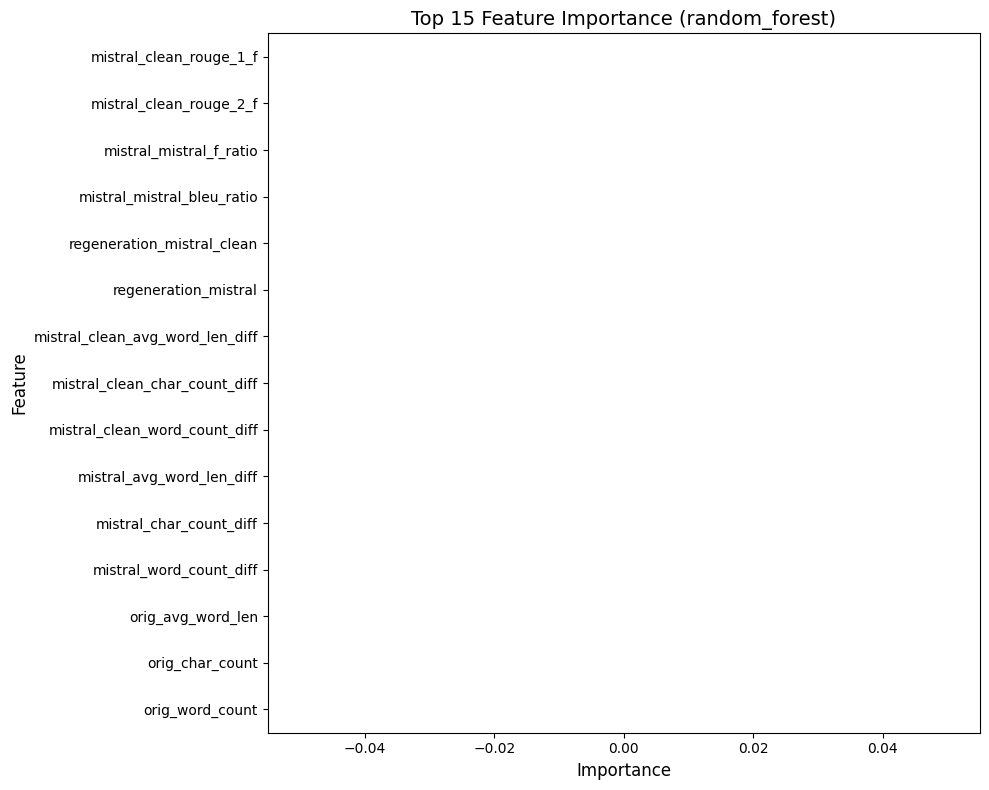

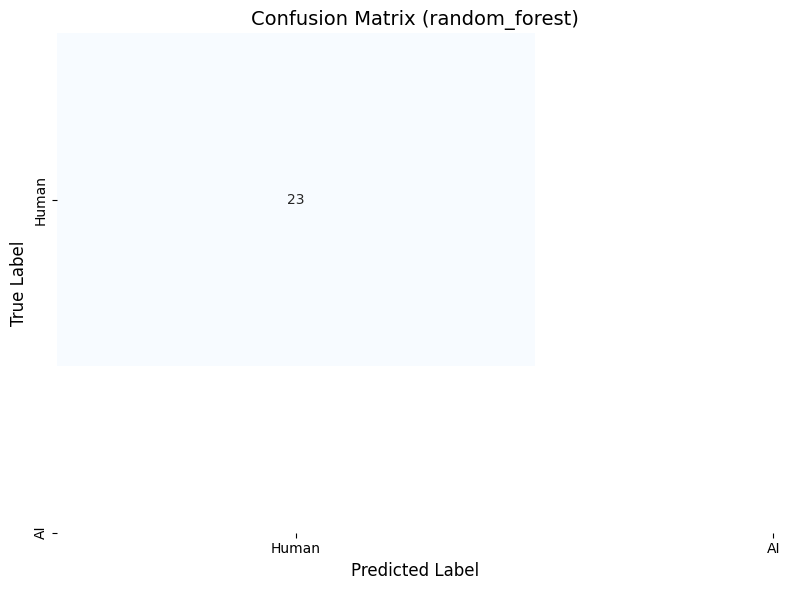

<Figure size 1000x800 with 0 Axes>

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.inspection import permutation_importance
import logging
import os
import joblib
from tqdm import tqdm
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

class AITextClassifier:
    """Class for AI-generated text classification."""
    
    def __init__(self, output_dir='data/models'):
        """
        Initialize the text classifier.
        
        Args:
            output_dir (str): Directory to save models and results
        """
        self.models = {}
        self.trained_models = {}
        self.results = {}
        self.output_dir = output_dir
        
        # Create output directory if it doesn't exist
        os.makedirs(output_dir, exist_ok=True)
        
        # Initialize default classifiers
        self._init_classifiers()
    
    def _init_classifiers(self):
        """Initialize the default set of classifiers."""
        self.models = {
            'random_forest': RandomForestClassifier(random_state=42),
            'gradient_boosting': GradientBoostingClassifier(random_state=42),
            'logistic_regression': LogisticRegression(max_iter=1000, random_state=42),
            'svm': SVC(probability=True, random_state=42)
        }
    
    def load_data(self, X_path, y_path, feature_names_path=None, test_size=0.2):
        """
        Load feature matrices and labels.
        
        Args:
            X_path (str): Path to feature matrix
            y_path (str): Path to labels
            feature_names_path (str): Path to feature names
            test_size (float): Proportion of data to use for testing
            
        Returns:
            tuple: (X_train, X_test, y_train, y_test)
        """
        logger.info(f"Loading data from {X_path} and {y_path}")
        
        # Load feature matrix and labels
        X = np.load(X_path)
        y = np.load(y_path)
        
        # Load feature names if provided
        self.feature_names = None
        if feature_names_path:
            try:
                with open(feature_names_path, 'r') as f:
                    self.feature_names = [line.strip() for line in f.readlines()]
                logger.info(f"Loaded {len(self.feature_names)} feature names")
            except Exception as e:
                logger.warning(f"Could not load feature names: {e}")
        
        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y
        )
        
        logger.info(f"Data split into training ({X_train.shape[0]} samples) and testing ({X_test.shape[0]} samples)")
        self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test
        
        return X_train, X_test, y_train, y_test
    
    def validate_data(self):
        """
        Validate the dataset to ensure it's suitable for training.
        
        Returns:
            bool: True if data is valid, False otherwise
        """
        if self.X_train is None or self.y_train is None:
            logger.error("No training data available")
            return False
        
        # Check for NaN values
        if np.isnan(self.X_train).any():
            logger.warning("NaN values found in training features")
            # Count NaN values per feature
            nan_counts = np.isnan(self.X_train).sum(axis=0)
            for i, count in enumerate(nan_counts):
                if count > 0:
                    feature_name = f"Feature_{i}" if self.feature_names is None else self.feature_names[i]
                    logger.warning(f"Feature '{feature_name}' has {count} NaN values")
        
        # Check class distribution
        unique_classes, class_counts = np.unique(self.y_train, return_counts=True)
        logger.info(f"Class distribution in training set: {dict(zip(unique_classes, class_counts))}")
        
        # Check for severe imbalance
        if len(unique_classes) < 2:
            logger.error("Only one class found in training data")
            return False
        
        min_class = np.min(class_counts)
        max_class = np.max(class_counts)
        imbalance_ratio = max_class / min_class
        
        if imbalance_ratio > 10:
            logger.warning(f"Severe class imbalance detected: {imbalance_ratio:.2f}:1 ratio")
        
        # Check feature variance
        feature_variance = np.var(self.X_train, axis=0)
        zero_var_features = np.where(feature_variance < 1e-10)[0]
        if len(zero_var_features) > 0:
            for idx in zero_var_features:
                feature_name = f"Feature_{idx}" if self.feature_names is None else self.feature_names[idx]
                logger.warning(f"Feature '{feature_name}' has near-zero variance")
        
        return True
    
    def add_classifier(self, name, classifier):
        """
        Add a custom classifier.
        
        Args:
            name (str): Name of the classifier
            classifier: Scikit-learn compatible classifier
        """
        self.models[name] = classifier
        logger.info(f"Added classifier: {name}")
    
    def optimize_hyperparameters(self, classifier_name, param_grid=None):
        """
        Optimize hyperparameters for a specific classifier.
        
        Args:
            classifier_name (str): Name of the classifier to optimize
            param_grid (dict): Parameter grid for grid search
            
        Returns:
            object: Best classifier
        """
        if classifier_name not in self.models:
            logger.error(f"Classifier '{classifier_name}' not found")
            return None
        
        if param_grid is None:
            # Default parameter grids
            if classifier_name == 'random_forest':
                param_grid = {
                    'n_estimators': [100, 200, 300],
                    'max_depth': [None, 10, 20, 30],
                    'min_samples_split': [2, 5, 10],
                    'min_samples_leaf': [1, 2, 4]
                }
            elif classifier_name == 'gradient_boosting':
                param_grid = {
                    'n_estimators': [100, 200, 300],
                    'learning_rate': [0.01, 0.1, 0.2],
                    'max_depth': [3, 5, 7]
                }
            elif classifier_name == 'logistic_regression':
                param_grid = {
                    'C': [0.01, 0.1, 1, 10, 100],
                    'solver': ['liblinear', 'saga']
                }
            elif classifier_name == 'svm':
                param_grid = {
                    'C': [0.1, 1, 10],
                    'kernel': ['linear', 'rbf'],
                    'gamma': ['scale', 'auto', 0.1, 1]
                }
            else:
                logger.warning(f"No default parameter grid for {classifier_name}, using default model")
                return self.models[classifier_name]
        
        logger.info(f"Optimizing hyperparameters for {classifier_name}")
        
        # Grid search with cross-validation
        grid_search = GridSearchCV(
            self.models[classifier_name],
            param_grid,
            cv=5,
            scoring='f1',
            n_jobs=-1,
            verbose=1
        )
        
        grid_search.fit(self.X_train, self.y_train)
        
        logger.info(f"Best parameters for {classifier_name}: {grid_search.best_params_}")
        logger.info(f"Best cross-validation score: {grid_search.best_score_:.4f}")
        
        # Update model with optimized version
        self.models[classifier_name] = grid_search.best_estimator_
        
        return grid_search.best_estimator_
    
    def train_all_models(self, optimize=False):
        """
        Train all classifiers on the training data.
        
        Args:
            optimize (bool): Whether to optimize hyperparameters before training
            
        Returns:
            dict: Dictionary of trained models
        """
        self.trained_models = {}
        
        # Check if we need to handle class imbalance
        unique_classes, class_counts = np.unique(self.y_train, return_counts=True)
        min_class = np.min(class_counts)
        max_class = np.max(class_counts)
        imbalance_ratio = max_class / min_class
        
        # If imbalance is significant, update classifiers to handle it
        if imbalance_ratio > 3:
            logger.warning(f"Class imbalance detected (ratio {imbalance_ratio:.2f}:1), adjusting models")
            
            # Update RandomForest
            if 'random_forest' in self.models:
                self.models['random_forest'] = RandomForestClassifier(
                    random_state=42,
                    class_weight='balanced',  # Add class weights
                    n_estimators=200  # More trees often help with imbalance
                )
            
            # Update GradientBoosting
            if 'gradient_boosting' in self.models:
                # GradientBoostingClassifier doesn't have class_weight
                # Adjust scale_pos_weight if binary classification
                if len(unique_classes) == 2:
                    pos_class_idx = list(unique_classes).index(1) if 1 in unique_classes else 1
                    pos_count = class_counts[pos_class_idx]
                    neg_count = sum(class_counts) - pos_count
                    scale_weight = neg_count / pos_count if pos_count > 0 else 1.0
                    
                    self.models['gradient_boosting'] = GradientBoostingClassifier(
                        random_state=42,
                        subsample=0.8,  # Help with imbalance
                        max_features=0.8  # Help with imbalance
                    )
            
            # Update Logistic Regression
            if 'logistic_regression' in self.models:
                self.models['logistic_regression'] = LogisticRegression(
                    max_iter=1000,
                    random_state=42,
                    class_weight='balanced'  # Add class weights
                )
            
            # Update SVM
            if 'svm' in self.models:
                self.models['svm'] = SVC(
                    probability=True,
                    random_state=42,
                    class_weight='balanced'  # Add class weights
                )
        
        for name, model in tqdm(self.models.items(), desc="Training models"):
            logger.info(f"Training {name}")
            
            try:
                if optimize:
                    self.optimize_hyperparameters(name)
                
                # Train the model
                model.fit(self.X_train, self.y_train)
                self.trained_models[name] = model
                
                # Make predictions and evaluate
                y_pred = model.predict(self.X_test)
                
                # Calculate metrics
                accuracy = accuracy_score(self.y_test, y_pred)
                precision = precision_score(self.y_test, y_pred, average='binary', zero_division=0)
                recall = recall_score(self.y_test, y_pred, average='binary', zero_division=0)
                f1 = f1_score(self.y_test, y_pred, average='binary', zero_division=0)
                
                logger.info(f"{name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
                
                # Save results
                self.results[name] = {
                    'accuracy': accuracy,
                    'precision': precision,
                    'recall': recall,
                    'f1': f1,
                    'model': model
                }
                
                # Save model
                joblib.dump(model, os.path.join(self.output_dir, f"{name}_model.joblib"))
            except Exception as e:
                logger.error(f"Error training model {name}: {e}")
        
        return self.trained_models
    
    def cross_validate_models(self, n_folds=5):
        """
        Perform cross-validation for all models.
        
        Args:
            n_folds (int): Number of cross-validation folds
            
        Returns:
            dict: Dictionary of cross-validation results
        """
        cv_results = {}
        
        # First check if we have enough samples of each class
        unique_classes, class_counts = np.unique(self.y_train, return_counts=True)
        logger.info(f"Class distribution in training set: {dict(zip(unique_classes, class_counts))}")
        
        # Make sure n_folds isn't larger than the smallest class count
        min_class_count = np.min(class_counts)
        if min_class_count < n_folds:
            old_n_folds = n_folds
            n_folds = min_class_count if min_class_count > 1 else 2
            logger.warning(f"Reducing n_folds from {old_n_folds} to {n_folds} due to class imbalance")
        
        # Define stratified k-fold cross-validator
        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
        
        # For handling potential errors
        error_score = 0.0
        
        for name, model in tqdm(self.models.items(), desc="Cross-validating"):
            logger.info(f"Cross-validating {name}")
            
            try:
                # Calculate cross-validation scores for multiple metrics
                # Set error_score to 0.0 to handle any failures gracefully
                accuracy = cross_val_score(model, self.X_train, self.y_train, cv=skf, 
                                          scoring='accuracy', error_score=error_score)
                precision = cross_val_score(model, self.X_train, self.y_train, cv=skf, 
                                           scoring='precision', error_score=error_score)
                recall = cross_val_score(model, self.X_train, self.y_train, cv=skf, 
                                        scoring='recall', error_score=error_score)
                f1 = cross_val_score(model, self.X_train, self.y_train, cv=skf, 
                                    scoring='f1', error_score=error_score)
                
                # Store results
                cv_results[name] = {
                    'accuracy': (accuracy.mean(), accuracy.std()),
                    'precision': (precision.mean(), precision.std()),
                    'recall': (recall.mean(), recall.std()),
                    'f1': (f1.mean(), f1.std())
                }
                
                logger.info(f"{name} - CV Accuracy: {accuracy.mean():.4f} ± {accuracy.std():.4f}, "
                            f"CV F1: {f1.mean():.4f} ± {f1.std():.4f}")
                
            except Exception as e:
                logger.error(f"Error during cross-validation of {name}: {str(e)}")
                # Store empty results
                cv_results[name] = {
                    'accuracy': (0.0, 0.0),
                    'precision': (0.0, 0.0),
                    'recall': (0.0, 0.0),
                    'f1': (0.0, 0.0)
                }
        
        return cv_results
    
    def calculate_feature_importance(self, model_name='random_forest'):
        """
        Calculate feature importance for a specific model.
        
        Args:
            model_name (str): Name of the model to use
            
        Returns:
            pd.DataFrame: DataFrame with feature importance scores
        """
        if model_name not in self.trained_models:
            logger.error(f"Model '{model_name}' not found in trained models")
            return None
        
        model = self.trained_models[model_name]
        
        # For tree-based models, use built-in feature importance
        if isinstance(model, (RandomForestClassifier, GradientBoostingClassifier)):
            importance = model.feature_importances_
            importance_type = "Built-in"
        else:
            # For other models, use permutation importance
            logger.info("Using permutation importance for non-tree-based model")
            result = permutation_importance(model, self.X_test, self.y_test, n_repeats=10, random_state=42)
            importance = result.importances_mean
            importance_type = "Permutation"
        
        # Create feature importance DataFrame
        if self.feature_names is not None and len(self.feature_names) == len(importance):
            feature_importance = pd.DataFrame({
                'Feature': self.feature_names,
                'Importance': importance,
                'Type': importance_type
            })
        else:
            feature_importance = pd.DataFrame({
                'Feature': [f"Feature_{i}" for i in range(len(importance))],
                'Importance': importance,
                'Type': importance_type
            })
        
        # Sort by importance
        feature_importance = feature_importance.sort_values('Importance', ascending=False)
        
        return feature_importance
    
    def plot_feature_importance(self, model_name='random_forest', top_n=15):
        """
        Plot feature importance for a specific model.
        
        Args:
            model_name (str): Name of the model to use
            top_n (int): Number of top features to show
            
        Returns:
            matplotlib.figure.Figure: Figure with feature importance plot
        """
        feature_importance = self.calculate_feature_importance(model_name)
        
        if feature_importance is None:
            return None
        
        # Get top N features
        top_features = feature_importance.head(top_n)
        
        # Create plot
        plt.figure(figsize=(10, 8))
        ax = sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
        plt.title(f'Top {top_n} Feature Importance ({model_name})', fontsize=14)
        plt.xlabel('Importance', fontsize=12)
        plt.ylabel('Feature', fontsize=12)
        plt.tight_layout()
        
        # Save figure
        plt.savefig(os.path.join(self.output_dir, f"{model_name}_feature_importance.png"), dpi=300, bbox_inches='tight')
        
        return plt.gcf()
    
    def plot_confusion_matrix(self, model_name='random_forest'):
        """
        Plot confusion matrix for a specific model.
        
        Args:
            model_name (str): Name of the model to use
            
        Returns:
            matplotlib.figure.Figure: Figure with confusion matrix plot
        """
        if model_name not in self.trained_models:
            logger.error(f"Model '{model_name}' not found in trained models")
            return None
        
        model = self.trained_models[model_name]
        
        # Generate predictions
        y_pred = model.predict(self.X_test)
        
        # Calculate confusion matrix
        cm = confusion_matrix(self.y_test, y_pred)
        
        # Plot
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'Confusion Matrix ({model_name})', fontsize=14)
        plt.ylabel('True Label', fontsize=12)
        plt.xlabel('Predicted Label', fontsize=12)
        
        # Add class labels
        plt.yticks([0.5, 1.5], ['Human', 'AI'])
        plt.xticks([0.5, 1.5], ['Human', 'AI'])
        
        plt.tight_layout()
        
        # Save figure
        plt.savefig(os.path.join(self.output_dir, f"{model_name}_confusion_matrix.png"), dpi=300, bbox_inches='tight')
        
        return plt.gcf()
    
    def plot_roc_curves(self):
        """
        Plot ROC curves for all trained models.
        
        Returns:
            matplotlib.figure.Figure: Figure with ROC curves plot
        """
        plt.figure(figsize=(10, 8))
        
        # Calculate and plot ROC curve for each model
        for name, model in self.trained_models.items():
            # Get probability predictions
            y_prob = model.predict_proba(self.X_test)[:, 1]
            
            # Calculate ROC curve
            fpr, tpr, _ = roc_curve(self.y_test, y_prob)
            auc = roc_auc_score(self.y_test, y_prob)
            
            # Plot ROC curve
            plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')
        
        # Add diagonal line
        plt.plot([0, 1], [0, 1], 'k--', label='Random')
        
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title('ROC Curves for AI Text Detection', fontsize=14)
        plt.legend(loc='lower right')
        plt.grid(alpha=0.3)
        
        # Save figure
        plt.savefig(os.path.join(self.output_dir, "roc_curves.png"), dpi=300, bbox_inches='tight')
        
        return plt.gcf()
    
    def plot_precision_recall_curves(self):
        """
        Plot Precision-Recall curves for all trained models.
        
        Returns:
            matplotlib.figure.Figure: Figure with Precision-Recall curves plot
        """
        plt.figure(figsize=(10, 8))
        
        # Calculate and plot PR curve for each model
        for name, model in self.trained_models.items():
            # Get probability predictions
            y_prob = model.predict_proba(self.X_test)[:, 1]
            
            # Calculate precision-recall curve
            precision, recall, _ = precision_recall_curve(self.y_test, y_prob)
            ap = average_precision_score(self.y_test, y_prob)
            
            # Plot PR curve
            plt.plot(recall, precision, label=f'{name} (AP = {ap:.3f})')
        
        plt.xlabel('Recall', fontsize=12)
        plt.ylabel('Precision', fontsize=12)
        plt.title('Precision-Recall Curves for AI Text Detection', fontsize=14)
        plt.legend(loc='lower left')
        plt.grid(alpha=0.3)
        
        # Save figure
        plt.savefig(os.path.join(self.output_dir, "precision_recall_curves.png"), dpi=300, bbox_inches='tight')
        
        return plt.gcf()
    
    def plot_metrics_comparison(self):
        """
        Plot comparison of metrics for all models.
        
        Returns:
            matplotlib.figure.Figure: Figure with metrics comparison plot
        """
        if not self.results:
            logger.error("No results available. Train models first.")
            return None
        
        # Prepare data for plotting
        models = list(self.results.keys())
        accuracy = [self.results[m]['accuracy'] for m in models]
        precision = [self.results[m]['precision'] for m in models]
        recall = [self.results[m]['recall'] for m in models]
        f1 = [self.results[m]['f1'] for m in models]
        
        # Set up the figure
        fig, ax = plt.subplots(figsize=(12, 8))
        
        # Set width of bars
        barWidth = 0.2
        
        # Set position of bars on X axis
        r1 = np.arange(len(models))
        r2 = [x + barWidth for x in r1]
        r3 = [x + barWidth for x in r2]
        r4 = [x + barWidth for x in r3]
        
        # Create bars
        ax.bar(r1, accuracy, width=barWidth, label='Accuracy', color='#4E79A7')
        ax.bar(r2, precision, width=barWidth, label='Precision', color='#F28E2B')
        ax.bar(r3, recall, width=barWidth, label='Recall', color='#E15759')
        ax.bar(r4, f1, width=barWidth, label='F1 Score', color='#76B7B2')
        
        # Add labels and legend
        ax.set_xlabel('Model', fontsize=12)
        ax.set_ylabel('Score', fontsize=12)
        ax.set_title('Performance Metrics by Model', fontsize=14)
        ax.set_xticks([r + barWidth*1.5 for r in range(len(models))])
        ax.set_xticklabels(models)
        ax.legend()
        
        # Add value labels on bars
        for i, rect in enumerate(ax.patches):
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)
        
        # Set y-axis limits to make room for labels
        ax.set_ylim(0, 1.1)
        
        plt.tight_layout()
        
        # Save figure
        plt.savefig(os.path.join(self.output_dir, "metrics_comparison.png"), dpi=300, bbox_inches='tight')
        
        return fig
    
    def generate_report(self):
        """
        Generate a comprehensive performance report.
        
        Returns:
            pd.DataFrame: DataFrame with performance metrics for all models
        """
        if not self.results:
            logger.error("No results available. Train models first.")
            return None
        
        # Create a DataFrame with all metrics
        report_data = {
            'Model': [],
            'Accuracy': [],
            'Precision': [],
            'Recall': [],
            'F1 Score': [],
            'AUC-ROC': []
        }
        
        for name, model in self.trained_models.items():
            # Get probability predictions
            y_prob = model.predict_proba(self.X_test)[:, 1]
            
            # Calculate AUC
            auc = roc_auc_score(self.y_test, y_prob)
            
            # Add to report
            report_data['Model'].append(name)
            report_data['Accuracy'].append(self.results[name]['accuracy'])
            report_data['Precision'].append(self.results[name]['precision'])
            report_data['Recall'].append(self.results[name]['recall'])
            report_data['F1 Score'].append(self.results[name]['f1'])
            report_data['AUC-ROC'].append(auc)
        
        # Create DataFrame
        report_df = pd.DataFrame(report_data)
        
        # Save report
        report_df.to_csv(os.path.join(self.output_dir, "model_performance_report.csv"), index=False)
        
        return report_df
    
    def predict(self, X, model_name=None):
        """
        Make predictions on new data.
        
        Args:
            X (numpy.ndarray): Feature matrix
            model_name (str): Name of model to use (if None, uses best model by F1 score)
            
        Returns:
            tuple: (predictions, probabilities)
        """
        if not self.trained_models:
            logger.error("No trained models available")
            return None, None
        
        # If no model specified, use the best model by F1 score
        if model_name is None:
            best_model_name = max(self.results, key=lambda k: self.results[k]['f1'])
            model = self.trained_models[best_model_name]
            logger.info(f"Using best model by F1 score: {best_model_name}")
        elif model_name in self.trained_models:
            model = self.trained_models[model_name]
            logger.info(f"Using specified model: {model_name}")
        else:
            logger.error(f"Model '{model_name}' not found in trained models")
            return None, None
        
        # Generate predictions and probabilities
        predictions = model.predict(X)
        probabilities = model.predict_proba(X)[:, 1]  # Probability of class 1 (AI)
        
        return predictions, probabilities

def main():
    """Demonstrate the classifier functionality."""
    try:
        # Initialize classifier
        classifier = AITextClassifier(output_dir='data/results')
        
        # Load data
        X_train, X_test, y_train, y_test = classifier.load_data(
            'data/processed/feature_matrix.npy',
            'data/processed/labels.npy',
            'data/processed/feature_names.txt'
        )
        
        # Validate data
        if not classifier.validate_data():
            logger.error("Data validation failed - fixing issues before proceeding")
            # Try to fix any issues with the data
            # Remove NaNs
            classifier.X_train = np.nan_to_num(classifier.X_train)
            classifier.X_test = np.nan_to_num(classifier.X_test)
        
        # Cross-validate models - wrap in try/except to continue even if one model fails
        try:
            cv_results = classifier.cross_validate_models(n_folds=5)
        except Exception as e:
            logger.error(f"Error during cross-validation: {e}")
            cv_results = {}
        
        # Train all models - handle each model separately
        for name in classifier.models.keys():
            try:
                logger.info(f"Training model: {name}")
                model = classifier.models[name]
                model.fit(classifier.X_train, classifier.y_train)
                classifier.trained_models[name] = model
                
                # Make predictions and evaluate
                y_pred = model.predict(classifier.X_test)
                
                # Calculate metrics
                accuracy = accuracy_score(classifier.y_test, y_pred)
                precision = precision_score(classifier.y_test, y_pred, average='binary', zero_division=0)
                recall = recall_score(classifier.y_test, y_pred, average='binary', zero_division=0)
                f1 = f1_score(classifier.y_test, y_pred, average='binary', zero_division=0)
                
                logger.info(f"{name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, "
                           f"Recall: {recall:.4f}, F1: {f1:.4f}")
                
                # Save results
                classifier.results[name] = {
                    'accuracy': accuracy,
                    'precision': precision,
                    'recall': recall,
                    'f1': f1,
                    'model': model
                }
                
                # Save model
                joblib.dump(model, os.path.join(classifier.output_dir, f"{name}_model.joblib"))
            except Exception as e:
                logger.error(f"Error training model {name}: {e}")
        
        # Generate visualizations for models that were successfully trained
        if classifier.trained_models:
            if 'random_forest' in classifier.trained_models:
                classifier.plot_feature_importance('random_forest')
                classifier.plot_confusion_matrix('random_forest')
            
            classifier.plot_roc_curves()
            classifier.plot_precision_recall_curves()
            classifier.plot_metrics_comparison()
            
            # Generate performance report
            report = classifier.generate_report()
            if report is not None:
                print("\nModel Performance Report:")
                print(report)
        else:
            logger.error("No models were successfully trained")
        
    except Exception as e:
        logger.error(f"Error in classifier demonstration: {e}")
        raise

if __name__ == "__main__":
    main()